# Devoir 4

Implémentation d'un SVM, MLP et d'un CNN.

In [0]:
!pip install kaggle

In [0]:
#code pour utiliser kaggle api dans codelab, et telecharger les donne dans le serveur
#suivre les etapes dans le lien:
#https://medium.com/@move37timm/using-kaggle-api-for-google-colaboratory-d18645f93648
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!kaggle competitions download -c ift3395-6390-f2018
!unzip -n train_images.npy.zip
!unzip -n test_images.npy.zip

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train_labels.csv: Skipping, found more recently modified local copy (use --force to force download)
test_images.npy.zip: Skipping, found more recently modified local copy (use --force to force download)
train_images.npy.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  train_images.npy.zip
Archive:  test_images.npy.zip


In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'




In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [4]:
#Load images with numpy
def randomize(a, b):
    #pris de:https://tech.pic-collage.com/tips-of-numpy-shuffle-multiple-arrays-e4fb3e7ae2a
    # Generate the permutation index array.
    permutation = np.random.permutation(a.shape[0])
    # Shuffle the arrays by giving the permutation in the square brackets.
    shuffled_a = a[permutation]
    shuffled_b = b[permutation]
    return shuffled_a, shuffled_b
import torch

images_train_raw = np.load('train_images.npy', encoding='latin1')
train_labels_raw = np.genfromtxt('train_labels.csv', names=True, delimiter=',', dtype=[('Id', 'i8'), ('Category', 'S5')])

#images_train_raw,train_labels_raw=randomize((images_train_raw),(train_labels_raw))



# Conversion des données pour PyTorch et prétraitement

In [7]:
# cette partie converti les donnes en tensor pour torch
#cette partie remplie la ram tres rapidement
#a ameliorer'
import torch
from collections import Counter
from scipy import ndimage
from skimage.filters.rank import entropy
from skimage.morphology import disk
torch.set_default_tensor_type('torch.DoubleTensor')
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
x_train =images_train_raw[:,1]
y_train =train_labels_raw
import cv2
import math
import os


num_classes=31
def class_to_num(string):
    words=['sink','pear','moust','nose','skate','pengu','peanu','skull','panda','paint','nail','apple','rifle','mug','sailb','pinea','spoon','rabbi','shove','rolle','screw','scorp','rhino','pool','octag','pillo','parro','squig','mouth','empty','penci']
    return words.index(string.decode('UTF-8'))
def num_to_class(num):
    words=['sink','pear','moustache','nose','skateboard','penguin','peanut','skull','panda','paintbrush','nail','apple','rifle','mug','sailboat','pineapple','spoon','rabbit','shovel','rollerskates','screwdriver','scorpion','rhinoceros','pool','octagon','pillow','parrot','squiggle','mouth','empty','pencil',]
    return words[int(num)]
def cookie_cutter(center_coo,img,step):
    img_dim=img.shape[0]
    #cette partie prend le centre d'entropie et coupe un caree autour:
    coo1=min(img_dim-step*2,max(0,center_coo[0]-step))
    coo2=max(step*2 ,min(100,center_coo[0]+step))
    coo3=min(img_dim-step*2,max(0,center_coo[1]-step))
    coo4=max(step*2 ,min(100,center_coo[1]+step))
    image_cut=img[coo1:coo2,coo3:coo4]
    return image_cut
def entropy_cut(img):
    #from skimage.filters.rank import entropy
    #from skimage.morphology import disk
    temp=np.uint8(img)#converti en int pour la fn entropy() , mais le centre de l'image original est utilisee
    cann = cv2.bilateralFilter(temp,9,100,100)
    #temp_img=np.where(img > 40, 1, 0)
    ent=entropy(cann,disk(10))
    indx_1d =np.argmax(ent)
    ent_center=np.unravel_index(indx_1d, (100,100))#coordonnes du centre d'enropie
    cut=cookie_cutter(ent_center,img,20)
    return cut
def centroid_cut(img):
    
    center=ndimage.measurements.center_of_mass(img)
    
    cut=cookie_cutter((math.floor(center[0]),math.floor(center[1])),img,16)
    return cut
def uber_cut(img):
    temp=np.where(img > 40, 1, 0)
    num,contour=cv2.connectedComponents(np.uint8(temp))
    s_countours=np.array(contour).reshape((100,100))
    sec_common=Counter(s_countours.flatten()).most_common(2)[1][0]
    
    
    s_countours_max=np.where(s_countours== (sec_common), 1, 0)
    
    filled_contour_max=ndimage.morphology.binary_fill_holes(s_countours_max)
    
    #isolated_img= np.multiply(img+(np.ones((100,100))*50) , filled_contour_max)#version avec coloriage
    isolated_img= np.multiply(img , filled_contour_max)
    return centroid_cut(isolated_img)

num_train=x_train.shape[0]

inputX=[]
labelY=[]
for i in range(y_train.shape[0]):
    labelY.append(  class_to_num( y_train[i][1] ) )
    #print( y_train[i][1],class_to_num( y_train[i][1] ))
for i in range(x_train.shape[0]):
    temp=uber_cut(x_train[i].reshape(100,100)).flatten()
    #temp=x_train[i]
    inputX.append( np.array(temp.tolist()))#.reshape(1,100,100)


from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(n_values=num_classes, sparse=False)
#y_train = one_hot.fit_transform(np.array([labelY]).reshape(-1,1))
#y_test = one_hot.transform(np.array([labelPrimeY]).reshape(-1,1))





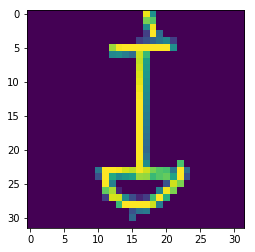

(0, b'shove')


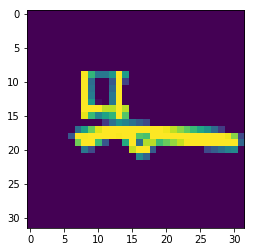

(1, b'rifle')


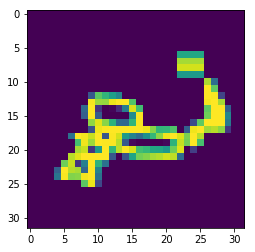

(2, b'scorp')


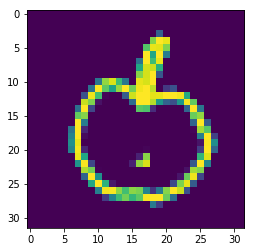

(3, b'apple')


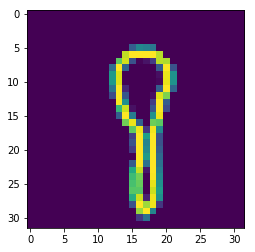

(4, b'spoon')


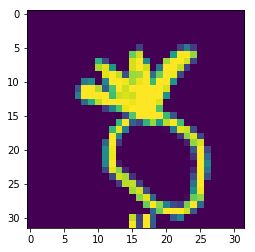

(5, b'pinea')


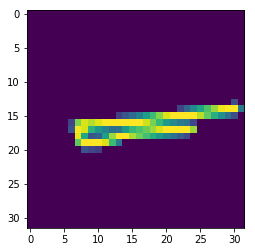

(6, b'rifle')


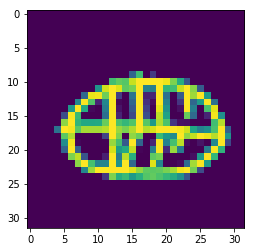

(7, b'mouth')


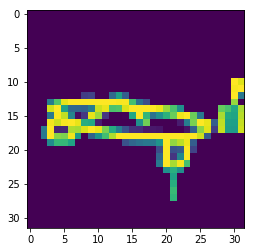

(8, b'skate')


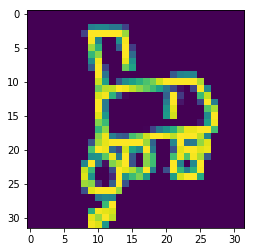

(9, b'rolle')


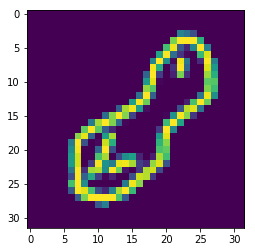

(10, b'peanu')


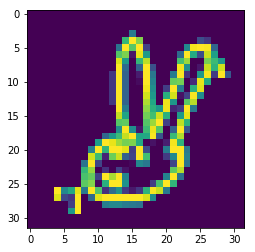

(11, b'rabbi')


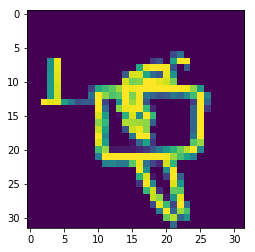

(12, b'sink')


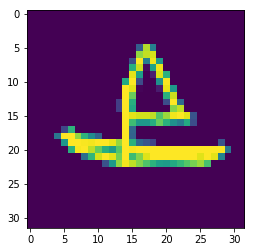

(13, b'sailb')


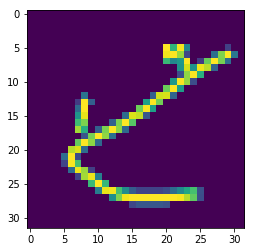

(14, b'nose')


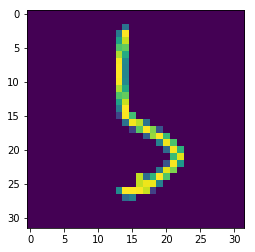

(15, b'nose')


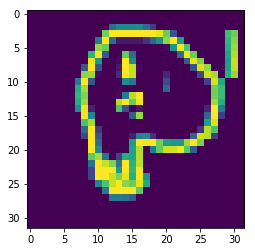

(16, b'skull')


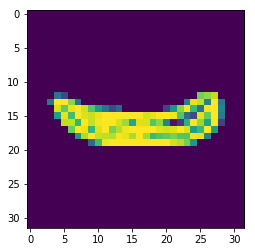

(17, b'mouth')


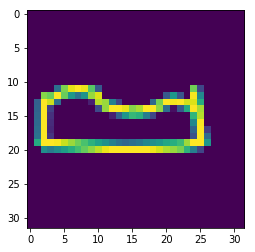

(18, b'pool')


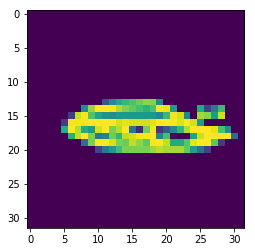

(19, b'mouth')


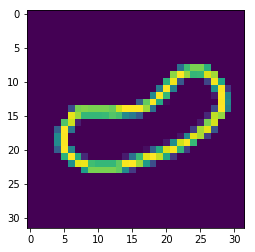

(20, b'peanu')


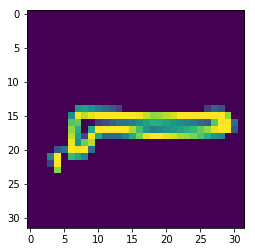

(21, b'rifle')


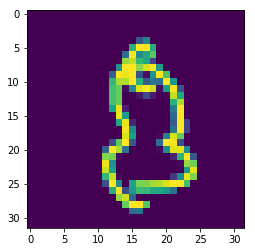

(22, b'pear')


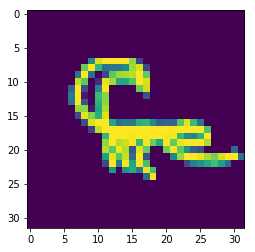

(23, b'scorp')


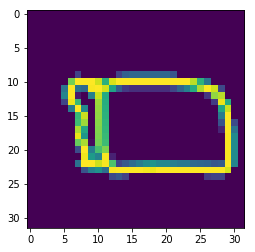

(24, b'pillo')


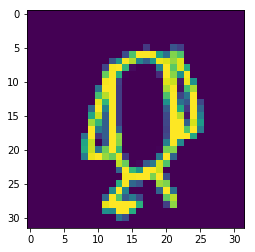

(25, b'pengu')


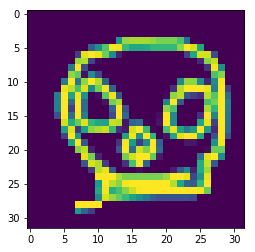

(26, b'skull')


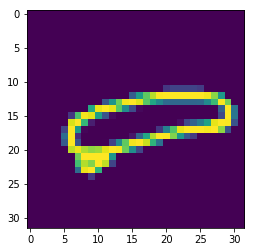

(27, b'skate')


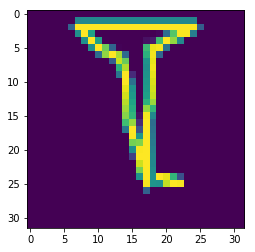

(28, b'nail')


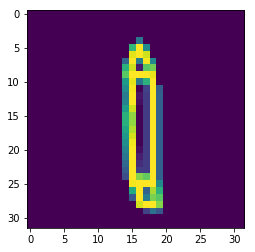

(29, b'penci')


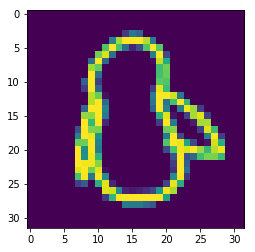

(30, b'pengu')


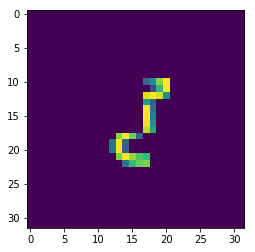

(31, b'empty')


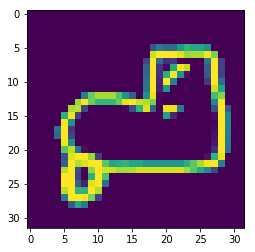

(32, b'rolle')


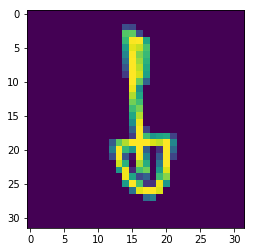

(33, b'shove')


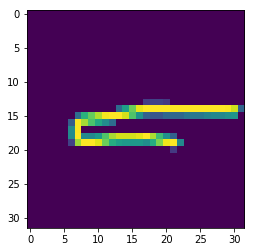

(34, b'rifle')


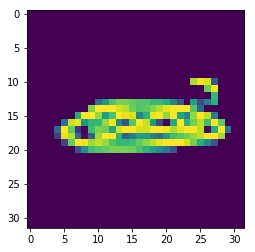

(35, b'pool')


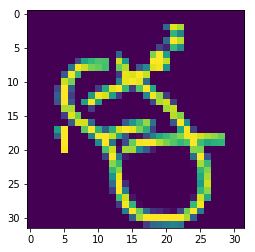

(36, b'peanu')


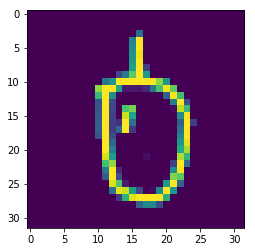

(37, b'pear')


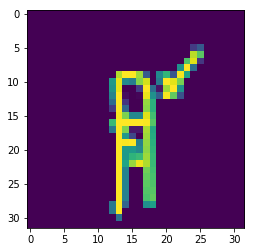

(38, b'nail')


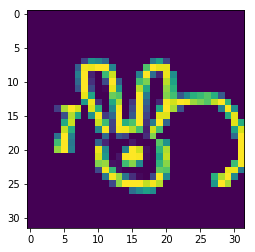

(39, b'rabbi')


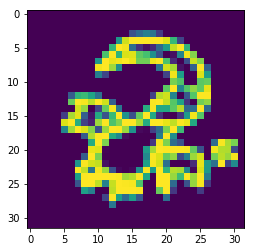

(40, b'scorp')


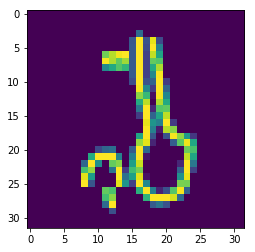

(41, b'spoon')


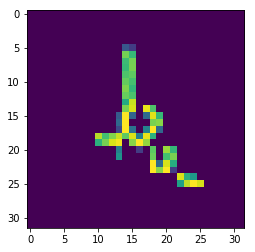

(42, b'spoon')


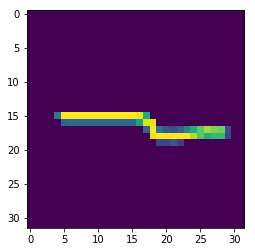

(43, b'rifle')


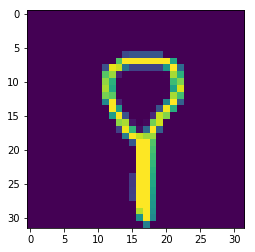

(44, b'spoon')


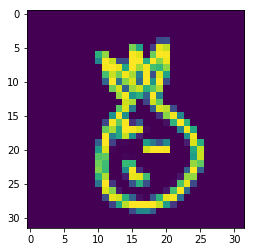

(45, b'pinea')


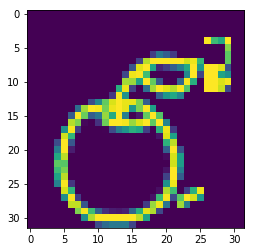

(46, b'apple')


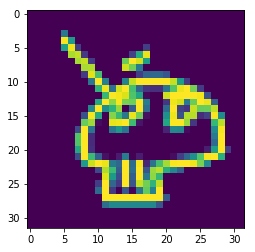

(47, b'skull')


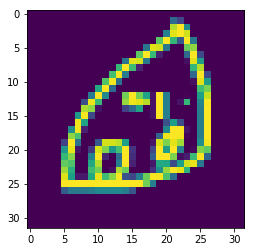

(48, b'nose')


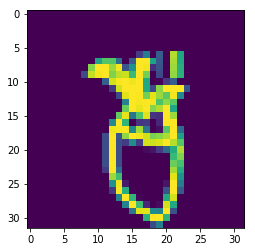

(49, b'pinea')


In [8]:
#pour voir si le reperage des dessins et decoupage se passe bien:
for i in range(50):
    image_ = inputX[i].reshape(32,32)
    plt.imshow(image_)
    plt.show() 
    print(train_labels_raw[i])

# Algorithme 1 - SVM

In [62]:
from sklearn import svm

clf = svm.SVC(kernel='linear', C=0.1)

train_data_SVM = inputX[:8000]
train_label_SVM = labelY[:8000]

valid_data_SVM = inputX[8000:]
valid_label_SVM = labelY[8000:]

clf.fit(train_data_SVM, train_label_SVM)
print("Done Training.")

def predictSVM(data, label):
    answer = clf.predict(valid_data_SVM)
    good_answer = 0
    bad_answer = 0
    for i in range(len(answer)):
        if(answer[i] == valid_label_SVM[i]):
            good_answer = good_answer + 1
        else:
            bad_answer = bad_answer + 1   
    result = 100*good_answer/(good_answer+bad_answer)
    return result

result = predictSVM(valid_data_SVM, valid_label_SVM)
print("Accuracy: " + str(result) + "%")

Done Training.
Accuracy: 43.0%
